## Synthetic simulation of historical TCs parameters using Gaussian copulas (Rueda et al. 2016) and subsequent selection of representative cases using Maximum Dissimilarity (MaxDiss) algorithm (Camus et al. 2011)

inputs required: 
  * Historical TC parameters that affect the site (output of notebook 03)
  * number of synthetic simulations to run
  * number of representative cases to be selected using MaxDiss

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.statistical import CopulaSimulation
from teslakit.mda import MaxDiss_Simplified_NoThreshold
from teslakit.plotting.storms import Plot_Params_Hist_vs_Sim_scatter, Plot_Params_Hist_vs_Sim_histogram, Plot_Params_MDA_vs_Sim_scatter



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

_, xds_TCs_r2_params = db.Load_TCs_r2_hist()  # TCs parameters inside radius 2

# TCs random generation and MDA parameters
num_sim_rnd = 100000
num_sel_mda = 1000



## Historical TCs - Probabilistic Simulation

In [4]:
# --------------------------------------
# Probabilistic simulation Historical TCs

# aux functions
def adjust_to_pareto(var):
    'Fix data. It needs to start at 0 for Pareto adjustment '
    var = var.astype(float)
    var_pareto =  np.amax(var) - var + 0.00001
    return var_pareto

def adjust_from_pareto(var_base, var_pareto):
    'Returns data from pareto adjustment'
    var = np.amax(var_base) - var_pareto + 0.00001
    return var


# use small radius parameters (4º)
pmean = xds_TCs_r2_params.pressure_mean.values[:]
pmin = xds_TCs_r2_params.pressure_min.values[:]
gamma = xds_TCs_r2_params.gamma.values[:]
delta = xds_TCs_r2_params.delta.values[:]
vmean = xds_TCs_r2_params.velocity_mean.values[:]

# fix pressure for p
pmean_p = adjust_to_pareto(pmean)
pmin_p = adjust_to_pareto(pmin)

# join storm parameters for copula simulation
storm_params = np.column_stack(
    (pmean_p, pmin_p, gamma, delta, vmean)
)

# statistical simulate PCs using copulas 
kernels = ['GPareto', 'GPareto', 'ECDF', 'ECDF', 'ECDF']
storm_params_sim = CopulaSimulation(storm_params, kernels, num_sim_rnd)

# adjust back pressures from pareto
pmean_sim = adjust_from_pareto(pmean, storm_params_sim[:,0])
pmin_sim = adjust_from_pareto(pmin, storm_params_sim[:,1])

# store simulated storms - parameters 
xds_TCs_r2_sim_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), pmean_sim),
        'pressure_min':(('storm'), pmin_sim),
        'gamma':(('storm'), storm_params_sim[:,2]),
        'delta':(('storm'), storm_params_sim[:,3]),
        'velocity_mean':(('storm'), storm_params_sim[:,4]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sim_rnd))    
    },
)
print(xds_TCs_r2_sim_params)

db.Save_TCs_r2_sim_params(xds_TCs_r2_sim_params)


<xarray.Dataset>
Dimensions:        (storm: 100000)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 ... 99995 99996 99997 99998 99999
Data variables:
    pressure_mean  (storm) float64 1.004e+03 1.002e+03 ... 1.003e+03 1.01e+03
    pressure_min   (storm) float64 1.006e+03 1.001e+03 ... 999.0 1.01e+03
    gamma          (storm) float64 158.8 82.83 138.2 69.99 ... 97.09 89.78 95.93
    delta          (storm) float64 157.0 163.6 169.7 106.6 ... 43.91 88.87 86.61
    velocity_mean  (storm) float64 26.7 24.54 31.68 11.21 ... 19.65 12.43 24.45


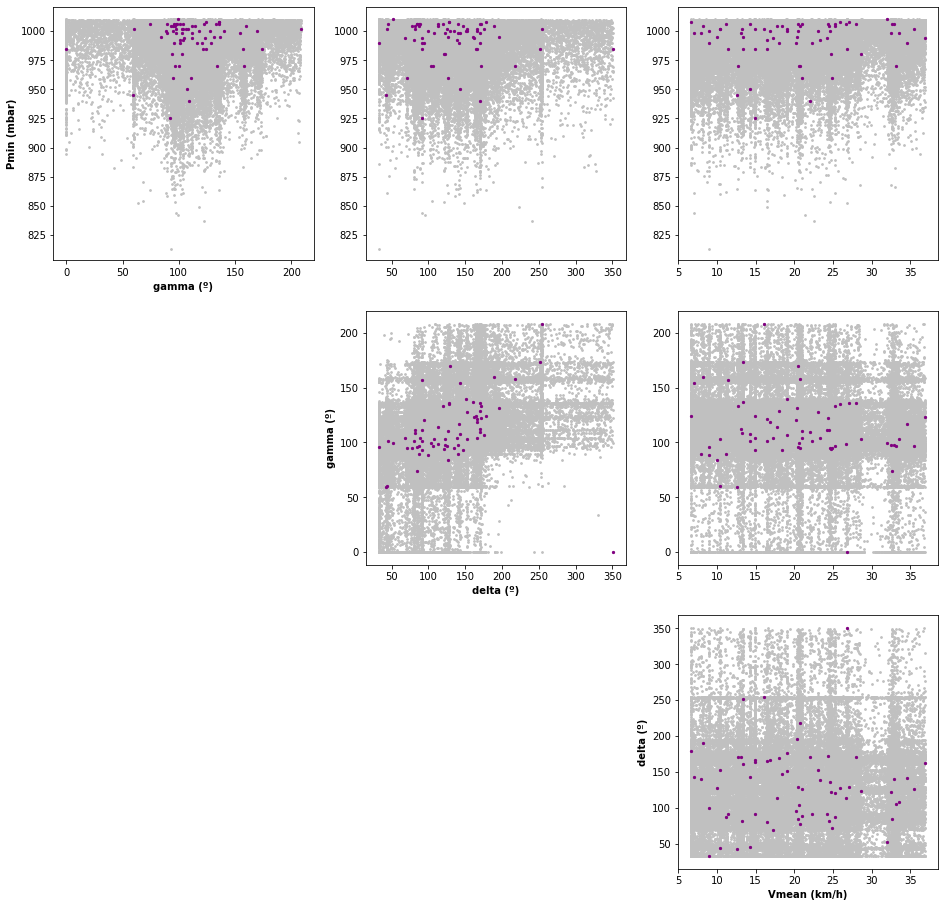

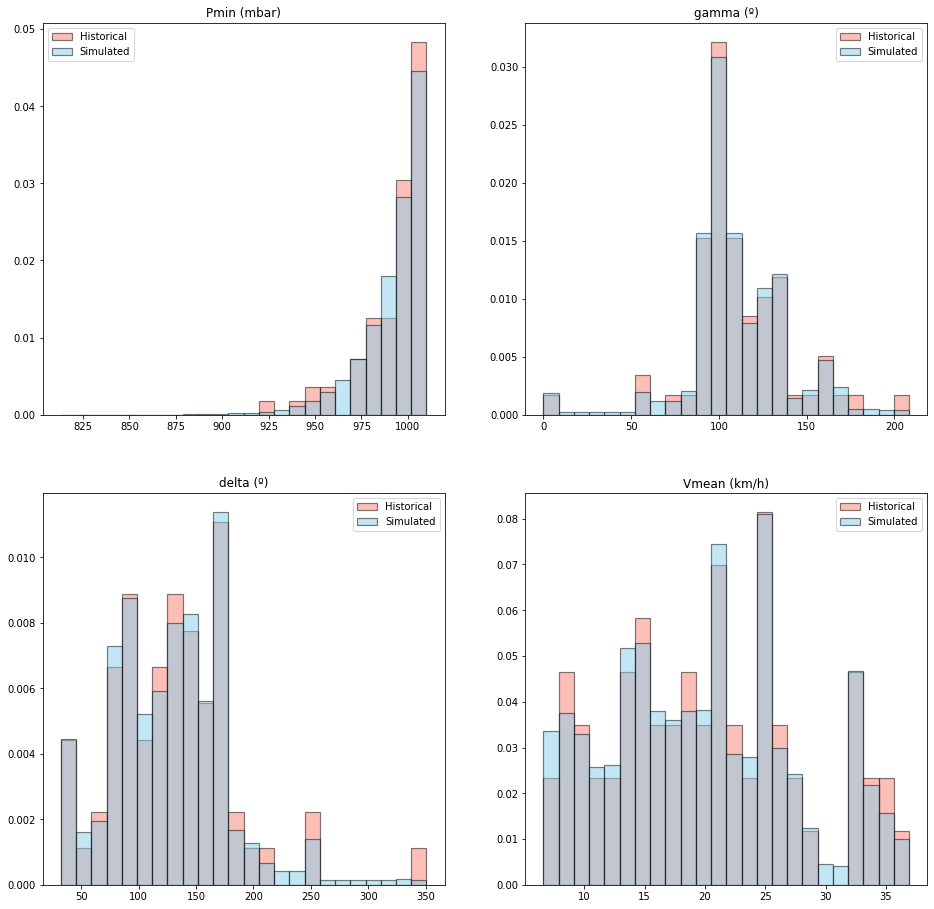

In [5]:
# Historical vs Simulated: scatter plot parameters
Plot_Params_Hist_vs_Sim_scatter(xds_TCs_r2_params, xds_TCs_r2_sim_params)

# Historical vs Simulated: histogram parameters
Plot_Params_Hist_vs_Sim_histogram(xds_TCs_r2_params, xds_TCs_r2_sim_params)



## Simulated TCs - MaxDiss classification

In [6]:
# --------------------------------------
# MaxDiss classification

# get simulated parameters  
pmean_s = xds_TCs_r2_sim_params.pressure_mean.values[:]
pmin_s  = xds_TCs_r2_sim_params.pressure_min.values[:]
gamma_s = xds_TCs_r2_sim_params.gamma.values[:]
delta_s = xds_TCs_r2_sim_params.delta.values[:]
vmean_s = xds_TCs_r2_sim_params.velocity_mean.values[:]

# subset, scalar and directional indexes
data_mda = np.column_stack((pmean_s, pmin_s, vmean_s, delta_s, gamma_s))
ix_scalar = [0,1,2]
ix_directional = [3,4]

centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)


# store MDA storms - parameters 
xds_TCs_r2_MDA_params = xr.Dataset(
    {
        'pressure_mean':(('storm'), centroids[:,0]),
        'pressure_min':(('storm'), centroids[:,1]),
        'velocity_mean':(('storm'), centroids[:,2]),
        'delta':(('storm'), centroids[:,3]),
        'gamma':(('storm'), centroids[:,4]),
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)
print(xds_TCs_r2_MDA_params)

db.Save_TCs_r2_mda_params(xds_TCs_r2_MDA_params)


MaxDiss waves parameters: 100000 --> 1000

   MDA centroids: 1000/1000

<xarray.Dataset>
Dimensions:        (storm: 1000)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    pressure_mean  (storm) float64 1.01e+03 885.8 996.4 ... 980.8 1.007e+03
    pressure_min   (storm) float64 1.01e+03 813.1 983.7 ... 978.7 1.005e+03
    velocity_mean  (storm) float64 35.8 8.993 6.622 6.622 ... 35.28 14.87 25.83
    delta          (storm) float64 80.59 32.39 262.2 99.76 ... 159.0 70.5 189.4
    gamma          (storm) float64 136.0 92.77 204.7 0.0 ... 88.4 111.7 121.3


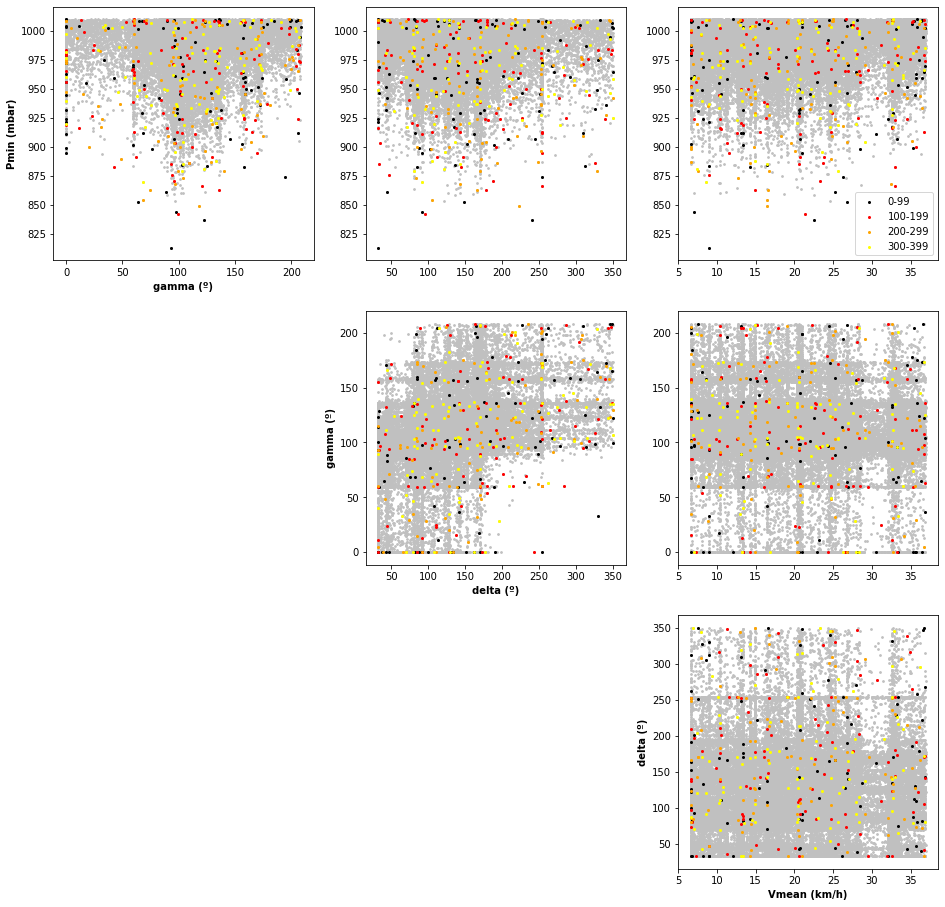

In [7]:
# Historical vs Simulated: scatter plot parameters
Plot_Params_MDA_vs_Sim_scatter(xds_TCs_r2_MDA_params, xds_TCs_r2_sim_params)


## Historical TCs (MDA centroids) Waves Simulation

Waves data is generated by numerically simulating selected storms. 

This methodology is not included inside teslakit python library.

This step needs to be done before continuing with notebook 05
